In [1]:
%matplotlib inline
import numpy as np
import numpy.ma as ma
import pandas as pd
from pandas import DataFrame, Series
import matplotlib.pyplot as plt
import seaborn as sns
import timeit
import line_profiler

import datetime

from io import StringIO
from pandas.api.types import CategoricalDtype

import pandas._testing as tm

# Pivot PivotTable stack unstack melt explode

In [22]:
def unpivot(frame):
    N, K = frame.shape
    data = {
        "value":frame.to_numpy().ravel("F"),
        "variable":np.asarray(frame.columns).repeat(N),
        "date":np.tile(np.asarray(frame.index), K)
    }
    return pd.DataFrame(data, columns=['date', 'variable', 'value'])

df = unpivot(tm.makeTimeDataFrame(3))
df.head()

,date,variable,value
0,2000-01-03,A,-1.129489
1,2000-01-04,A,0.884005
2,2000-01-05,A,0.602088
3,2000-01-03,B,0.132881
4,2000-01-04,B,-1.495405


In [26]:
df.pivot(index='date', columns='variable', values='value')

variable,A,B,C,D
date,,,,
2000-01-03,-1.129489,0.132881,-0.675755,-0.330380
2000-01-04,0.884005,-1.495405,0.270740,-1.124825
2000-01-05,0.602088,0.875596,-1.324956,-0.294233


In [27]:
df["value2"] = df["value"] * 2
df.head()

,date,variable,value,value2
0,2000-01-03,A,-1.129489,-2.258979
1,2000-01-04,A,0.884005,1.768011
2,2000-01-05,A,0.602088,1.204176
3,2000-01-03,B,0.132881,0.265763
4,2000-01-04,B,-1.495405,-2.990810


In [31]:
pivoted = df.pivot(index='date', columns='variable')
pivoted['value2']

variable,A,B,C,D
date,,,,
2000-01-03,-2.258979,0.265763,-1.351510,-0.660759
2000-01-04,1.768011,-2.990810,0.541480,-2.249649
2000-01-05,1.204176,1.751193,-2.649912,-0.588467


In [39]:
tuples = list(zip(*[
    [ "bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux", ],
    [ "one", "two", "one", "two", "one", "two", "one", "two", ],
]))

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])

df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one     0.441236  0.887606
      two     0.650041  2.448718
baz   one    -0.527134 -0.749858
      two    -0.911297  1.284420

In [61]:
stacked = df2.stack()
stacked

first  second   
bar    one     A    0.441236
               B    0.887606
       two     A    0.650041
               B    2.448718
baz    one     A   -0.527134
               B   -0.749858
       two     A   -0.911297
               B    1.284420
dtype: float64

In [58]:
%timeit stacked.unstack()

945 µs ± 21.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [60]:
%timeit stacked.reset_index().rename(columns={"level_2":"col1", 0:"col2"}).pivot_table(index=['first', 'second'], columns='col1', values='col2')

10.3 ms ± 102 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [70]:
index = pd.MultiIndex.from_product([[2, 1], ["a", "b"]])
df = pd.DataFrame(np.random.randn(4), index=index, columns=["A"])
print(df)
all(df.unstack().stack() == df.sort_index())

            A
2 a  0.446744
  b -1.484540
1 a  0.808466
  b -0.627887


True

In [75]:
columns = pd.MultiIndex.from_tuples([
    ("A", "cat", "long"), ("B", "cat", "long"),
    ("A", "dog", "short"), ("B", "dog", "short"),
], names=["exp", "animal", "hair_length"],)
df = pd.DataFrame(np.random.randn(4, 4), columns=columns)
df.stack(level=["animal", "hair_length"])
df.stack(level=[1,2])

exp                          A         B
  animal hair_length                    
0 cat    long        -0.345836 -0.017420
  dog    short       -1.825979  0.887327
1 cat    long         1.480182 -0.101710
  dog    short       -2.072065 -2.310006
2 cat    long        -0.338607  0.752293
  dog    short        1.229075 -1.032769
3 cat    long         0.739229  0.216387
  dog    short        1.005689  1.015874

In [3]:
columns = pd.MultiIndex.from_tuples(
    [("A", "cat"), ("B", "dog"), ("B", "cat"),("A", "dog"),],
    names=['exp', "animals"]
)
index = pd.MultiIndex.from_product([("bar", "baz", "foo", "qux"), ("one", "two")], 
                                   names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 4), index=index, columns=columns)
df2 = df.iloc[[0, 1, 2, 4, 5, 7]]

In [132]:
df2.stack('exp')
df.stack('animals')

exp                          A         B
first second animals                    
bar   one    cat     -1.277764  0.544884
             dog     -2.006077  0.755430
      two    cat      0.680017  0.111496
             dog      1.079009  0.045822
baz   one    cat      1.357956 -1.623726
             dog      1.015614  0.599910
      two    cat     -0.932898  1.390138
             dog      0.252586 -0.593359
foo   one    cat     -1.479511  1.091047
             dog      0.132800 -0.057754
      two    cat      0.527948  0.127214
             dog     -0.133948  0.388487
qux   one    cat     -0.206994 -0.849301
             dog     -0.934951  0.050359
      two    cat      0.310999  2.318594
             dog     -0.732711 -0.494976

In [136]:
df3 = df.iloc[[0, 1, 4, 7], [1, 2]]
df3.unstack()

exp             B                              
animals       dog                 cat          
second        one       two       one       two
first                                          
bar      0.755430  0.045822  0.544884  0.111496
foo     -0.057754       NaN  1.091047       NaN
qux           NaN -0.494976       NaN  2.318594

In [137]:
df3.unstack(fill_value=0.)

exp             B                              
animals       dog                 cat          
second        one       two       one       two
first                                          
bar      0.755430  0.045822  0.544884  0.111496
foo     -0.057754  0.000000  1.091047  0.000000
qux      0.000000 -0.494976  0.000000  2.318594

In [156]:
df[:3].unstack(0)

exp             A                   B                                       A  \
animals       cat                 dog                 cat                 dog   
first         bar       baz       bar       baz       bar       baz       bar   
second                                                                          
one     -0.533941  1.510495  0.520594  0.848948  0.490015 -0.437616  2.417119   
two      1.405792       NaN -0.234288       NaN -0.588648       NaN -0.650806   

exp                
animals            
first         baz  
second             
one     -1.314637  
two           NaN

In [158]:
df[:3].unstack(1)

exp             A                   B                                       A  \
animals       cat                 dog                 cat                 dog   
second        one       two       one       two       one       two       one   
first                                                                           
bar     -0.533941  1.405792  0.520594 -0.234288  0.490015 -0.588648  2.417119   
baz      1.510495       NaN  0.848948       NaN -0.437616       NaN -1.314637   

exp                
animals            
second        two  
first              
bar     -0.650806  
baz           NaN

In [169]:
df = DataFrame({
    'fr':[1.1, 2.9],
    'var':['10px', '12pz']
})
df.melt(id_vars='fr', var_name='Ramesh', value_name='ValueSuresh')

,fr,Ramesh,ValueSuresh
0,1.1,var,10px
1,2.9,var,12pz


In [174]:
cheese = pd.DataFrame({
    "first": ["John", "Mary"],
    "last": ["Doe", "Bo"],
    "height": [5.5, 6.0],
    "weight": [130, 150],
})
print(cheese)
cheese.melt(id_vars=['first', 'last'], var_name='quantity')

  first last  height  weight
0  John  Doe     5.5     130
1  Mary   Bo     6.0     150


,first,last,quantity,value
0,John,Doe,height,5.5
1,Mary,Bo,height,6.0
2,John,Doe,weight,130.0
3,Mary,Bo,weight,150.0


In [178]:
index = pd.MultiIndex.from_tuples([("person", "A"), ("person", "B")])
cheese = pd.DataFrame({
    "first": ["John", "Mary"],
    "last": ["Doe", "Bo"],
    "height": [5.5, 6.0],
    "weight": [130, 150],
}, index=index)

cheese.melt(id_vars=["first", "last"], ignore_index=False)

first last variable  value
person A  John  Doe   height    5.5
       B  Mary   Bo   height    6.0
       A  John  Doe   weight  130.0
       B  Mary   Bo   weight  150.0

In [2]:
dft = pd.DataFrame({
    "A1970": {0: "a", 1: "b", 2: "c"},
    "A1980": {0: "d", 1: "e", 2: "f"},
    "B1970": {0: 2.5, 1: 1.2, 2: 0.7},
    "B1980": {0: 3.2, 1: 1.3, 2: 0.1},
    "X": dict(zip(range(3), np.random.randn(3))),
})

dft["id"] = dft.index
pd.wide_to_long(dft, ["A", "B"], i="id", j="year")

,,X,A,B
id,year,,,
0,1970,2.294213,a,2.5
1,1970,0.536097,b,1.2
2,1970,1.251835,c,0.7
0,1980,2.294213,d,3.2
1,1980,0.536097,e,1.3
2,1980,1.251835,f,0.1


In [14]:
df

exp                  A         B                   A
animals            cat       dog       cat       dog
first second                                        
bar   one    -0.195013 -0.286678 -0.118200  0.281041
      two     0.965683 -0.026230  0.640342  1.342184
baz   one     0.618773 -0.669141  1.516334  0.563550
      two     0.632048  1.271618  0.266675 -0.904085
foo   one    -1.562026  0.123651 -0.766859  0.474332
      two    -0.125325 -0.878116  1.785332 -0.200733
qux   one     1.195505  0.109693 -0.204938  0.625577
      two    -0.429843 -0.764270  0.807109  0.609110

In [12]:
%timeit df.stack().mean(axis=1).unstack()

5.13 ms ± 368 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [13]:
%timeit df.groupby(level=1, axis=1).mean()

1.77 ms ± 155 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [17]:
%timeit df.stack().groupby(level=1).mean() # 4.98 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)

4.98 ms ± 369 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [18]:
%timeit df.mean().unstack(0) # 1.7 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

1.7 ms ± 165 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [20]:
import datetime
df = pd.DataFrame({
    "A": ["one", "one", "two", "three"] * 6,
    "B": ["A", "B", "C"] * 8,
    "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 4,
    "D": np.random.randn(24),
    "E": np.random.randn(24),
    "F": [datetime.datetime(2013, i, 1) for i in range(1, 13)] + [datetime.datetime(2013, i, 15) for i in range(1, 13)],
})
df.head()

,A,B,C,D,E,F
0,one,A,foo,-1.085904,0.976838,2013-01-01
1,one,B,foo,-0.210566,-1.102500,2013-02-01
2,two,C,foo,-1.665817,-1.252759,2013-03-01
3,three,A,bar,-0.626337,-0.017486,2013-04-01
4,one,B,bar,0.008965,0.296896,2013-05-01


In [30]:
pd.pivot_table(df, values='D', index=['A','B'], columns="C")
pd.pivot_table(df, values='D', index=['B'], columns="C", aggfunc=np.sum)
pd.pivot_table(df, index=['A','B'], columns=["C"], aggfunc=np.sum)
pd.pivot_table(df, values='D', 
               index=pd.Grouper(freq='3M', key='F'), columns='C')

C,bar,foo
F,,
2013-01-31,NaN,0.399009
2013-04-30,-0.733485,-0.297026
2013-07-31,0.329096,0.532486
2013-10-31,-0.133407,1.348178
2014-01-31,0.424551,NaN


In [32]:
table = pd.pivot_table(df, index=['A','B'], columns='C')
print(table.to_string(na_rep=''))

                D                   E          
C             bar       foo       bar       foo
A     B                                        
one   A -0.133407  0.399009  0.809248  0.057943
      B  0.025018 -0.584340 -0.092106 -0.794168
      C  0.633173  1.800555 -1.984427 -1.092609
three A -0.733485            0.014646          
      B            0.895802           -0.343095
      C  1.179198            0.776831          
two   A            0.532486            0.087111
      B -0.330097           -0.213255          
      C           -0.009711           -0.635694


In [34]:
df.head()

,A,B,C,D,E,F
0,one,A,foo,-1.085904,0.976838,2013-01-01
1,one,B,foo,-0.210566,-1.102500,2013-02-01
2,two,C,foo,-1.665817,-1.252759,2013-03-01
3,three,A,bar,-0.626337,-0.017486,2013-04-01
4,one,B,bar,0.008965,0.296896,2013-05-01


In [35]:
df.pivot_table(index=['A', 'B'], columns='C', margins=True, aggfunc=np.sum)

D                             E                    
C             bar       foo       All       bar       foo       All
A     B                                                            
one   A -0.266814  0.798018  0.531204  1.618497  0.115885  1.734382
      B  0.050036 -1.168680 -1.118644 -0.184212 -1.588336 -1.772548
      C  1.266347  3.601109  4.867456 -3.968853 -2.185217 -6.154070
three A -1.466970       NaN -1.466970  0.029293       NaN  0.029293
      B       NaN  1.791604  1.791604       NaN -0.686191 -0.686191
      C  2.358396       NaN  2.358396  1.553662       NaN  1.553662
two   A       NaN  1.064972  1.064972       NaN  0.174223  0.174223
      B -0.660193       NaN -0.660193 -0.426511       NaN -0.426511
      C       NaN -0.019422 -0.019422       NaN -1.271387 -1.271387
All      1.280802  6.067601  7.348403 -1.378124 -5.441023 -6.819147

In [41]:
foo, bar, dull, shiny, one, two = "foo", "bar", "dull", "shiny", "one", "two"
a = np.array([foo, foo, bar, bar, foo, foo], dtype=object)
b = np.array([one, one, two, one, two, one], dtype=object)
c = np.array([dull, dull, shiny, dull, dull, shiny], dtype=object)

pd.crosstab(a,[b,c], rownames=["a"], colnames=["b", "c"])

b    one        two      
c   dull shiny dull shiny
a                        
bar    1     0    0     1
foo    2     1    1     0

In [46]:
df = pd.DataFrame({
    "A": [1, 2, 2, 2, 2], "B": [3, 3, 4, 4, 4], "C": [1, 1, np.nan, 1, 1]
})
pd.crosstab(df['A'], df['B'], margins=True)

B,3,4,All
A,,,
1,1,0,1
2,1,3,4
All,2,3,5


In [47]:
foo = pd.Categorical(["a", "b"], categories=["a", "b", "c"])
bar = pd.Categorical(["d", "e"], categories=["d", "e", "f"])
pd.crosstab(foo, bar)

col_0,d,e
row_0,,
a,1,0
b,0,1


In [54]:
ages = np.array([1, 2, 4, 3, 8, 6])
pd.cut(ages, bins=3)

[(0.993, 3.333], (0.993, 3.333], (3.333, 5.667], (0.993, 3.333], (5.667, 8.0], (5.667, 8.0]]
Categories (3, interval[float64]): [(0.993, 3.333] < (3.333, 5.667] < (5.667, 8.0]]

In [59]:
c = pd.cut(ages, bins=[0, 3, 6, 9])
c

[(0, 3], (0, 3], (3, 6], (0, 3], (6, 9], (3, 6]]
Categories (3, interval[int64]): [(0, 3] < (3, 6] < (6, 9]]

In [64]:
df = pd.DataFrame({"key": list("bbac"), "data1": range(4)})
print(df)
pd.get_dummies(df['key'])

  key  data1
0   b      0
1   b      1
2   a      2
3   c      3


,a,b,c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1


In [65]:
dummies = pd.get_dummies(df["key"], prefix="key")
dummies

,key_a,key_b,key_c
0,0,1,0
1,0,1,0
2,1,0,0
3,0,0,1


In [66]:
df[["data1"]].join(dummies)

,data1,key_a,key_b,key_c
0,0,0,1,0
1,1,0,1,0
2,2,1,0,0
3,3,0,0,1


In [69]:
values = np.random.randn(10)
bins = [0, 0.2, 0.4, 0.6, 0.8, 1]
print(values)

[-0.14830284 -0.40201434  0.63955668 -0.0149193  -1.5780331   0.77066684
 -0.00256369 -0.32198427  0.62773557 -1.41595059]


In [72]:
pd.cut(values, bins)
pd.get_dummies(pd.cut(values, bins))

,"(0.0, 0.2]","(0.2, 0.4]","(0.4, 0.6]","(0.6, 0.8]","(0.8, 1.0]"
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,1,0
3,0,0,0,0,0
4,0,0,0,0,0
5,0,0,0,1,0
6,0,0,0,0,0
7,0,0,0,0,0
8,0,0,0,1,0
9,0,0,0,0,0


In [74]:
df = pd.DataFrame({"A": ["a", "b", "a"], "B": ["c", "c", "b"], 
                   "C": [1, 2,3]})
pd.get_dummies(df)

,C,A_a,A_b,B_b,B_c
0,1,1,0,0,1
1,2,0,1,0,1
2,3,1,0,1,0


In [88]:
x = pd.Series(["A", "A", np.nan, "B", 3.14, np.inf])
print(x)
pd.factorize(x)

0       A
1       A
2     NaN
3       B
4    3.14
5     inf
dtype: object


(array([ 0,  0, -1,  1,  2,  3]), Index(['A', 'B', 3.14, inf], dtype='object'))

In [86]:
print(np.unique([1,3,1,2,5,np.nan,np.inf, np.nan]))
print(pd.factorize([1,3,1,2,5,np.nan, np.inf, np.nan]))

[ 1.  2.  3.  5. inf nan nan]
(array([ 0,  1,  0,  2,  3, -1,  4, -1]), array([ 1.,  3.,  2.,  5., inf]))


In [110]:
x = pd.Series(['A', 'A', np.nan, 'B', 3.14, np.inf])
pd.factorize(x, sort=True)
#np.unique(x, return_inverse=True)[::-1] # TypeError: '<' not supported between instances of 'float' and 'str'


(array([ 2,  2, -1,  3,  0,  1]), Index([3.14, inf, 'A', 'B'], dtype='object'))

In [112]:
np.random.seed([3, 1415])
n = 20
cols = np.array(["key", "row", "item", "col"])
df = cols + pd.DataFrame((np.random.randint(5, size=(n, 4)) // [2, 1, 2, 1]).astype(str))
df.columns = cols
df = df.join(pd.DataFrame(np.random.rand(n, 2).round(2)).add_prefix("val"))
df.head(3)

,key,row,item,col,val0,val1
0,key0,row3,item1,col3,0.81,0.04
1,key1,row2,item1,col2,0.44,0.07
2,key1,row0,item1,col0,0.77,0.01


In [120]:
%timeit df.pivot_table(columns='col', index='row', values='val0', aggfunc=['sum', 'mean'])

17.5 ms ± 278 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [123]:
df.pivot_table(columns=['item','col'], index='row', values=['val0', 'val1'],)

val0                                                         ...  val1  \
item item0             item1                         item2         ... item0   
col   col2  col3  col4  col0  col1  col2  col3  col4  col0   col1  ...  col4   
row                                                                ...         
row0   NaN   NaN   NaN  0.77   NaN   NaN   NaN   NaN   NaN  0.605  ...   NaN   
row2  0.35   NaN  0.37   NaN   NaN  0.44   NaN   NaN  0.13    NaN  ...   0.7   
row3   NaN   NaN   NaN   NaN  0.31   NaN  0.81   NaN   NaN    NaN  ...   NaN   
row4  0.15  0.64   NaN   NaN  0.10  0.64  0.88  0.24   NaN    NaN  ...   NaN   

                                                             
item item1                         item2                     
col   col0  col1  col2  col3  col4  col0   col1  col3  col4  
row                                                          
row0  0.01   NaN   NaN   NaN   NaN   NaN  0.745  0.01  0.02  
row2   NaN   NaN  0.07   NaN   NaN  0.45    NaN  0.44  0.88  
row3   NaN  0.23   NaN  0.04   NaN   NaN    NaN  0.11   NaN  
row4   NaN  0.07  0.25  0.39  0.46   NaN    NaN   NaN   NaN  

[4 rows x 24 columns]

In [124]:
keys = ["panda1", "panda2", "panda3"]
values = [["eats", "shoots"], ["shoots", "leaves"], ["eats", "leaves"]]
df = pd.DataFrame({"keys": keys, "values": values})
df

,keys,values
0,panda1,"[eats, shoots]"
1,panda2,"[shoots, leaves]"
2,panda3,"[eats, leaves]"


In [126]:
df.explode("values")

,keys,values
0,panda1,eats
0,panda1,shoots
1,panda2,shoots
1,panda2,leaves
2,panda3,eats
2,panda3,leaves


In [132]:
s = pd.Series([[1, 2, 3], "foo", [], ["a", "b"]])
s.explode().reset_index(drop=True)

0      1
1      2
2      3
3    foo
4    NaN
5      a
6      b
dtype: object

In [135]:
df = pd.DataFrame([{"var1": "a,b,c", "var2": 1}, 
                   {"var1": "d,e,f", "var2": 2}])
df.assign(var1=df.var1.str.split(',')).explode('var1')

,var1,var2
0,a,1
0,b,1
0,c,1
1,d,2
1,e,2
1,f,2


# 2.9 Working with text data

In [148]:
s = pd.Series(["a", None, "b","a"], dtype="string")
s.str.isdigit() # boolean
s.dropna().str.match("a") # boolean

0    False
1     <NA>
2    False
3    False
dtype: boolean

In [150]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"], 
              dtype='string')
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5    <NA>
6    caba
7     dog
8     cat
dtype: string

In [153]:
idx = pd.Index([" jack", "jill ", " jesse ", "frank"])
idx.str.strip()
idx.str.lstrip()
idx.str.rstrip()

Index([' jack', 'jill', ' jesse', 'frank'], dtype='object')

In [158]:
df = pd.DataFrame(np.random.randn(3, 2), 
                  columns=[" Column A ", " Column B "],
                  index=range(3))
df.columns.str.strip()
df.columns.str.lower()
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df

,column_a,column_b
0,1.232895,-0.391184
1,-0.990020,2.110520
2,0.062507,-0.671785


In [164]:
s3 = pd.Series(["base", "A", "B", "C", "Aaba", "Baca", "", np.nan, "CABA", "dog", "cat"],
               dtype='string')
print(s3)
s3.str.replace("^.a|dog", "XX-XX", case=False, regex=True)

0     base
1        A
2        B
3        C
4     Aaba
5     Baca
6         
7     <NA>
8     CABA
9      dog
10     cat
dtype: string


0     XX-XXse
1           A
2           B
3           C
4     XX-XXba
5     XX-XXca
6            
7        <NA>
8     XX-XXBA
9       XX-XX
10     XX-XXt
dtype: string

In [166]:
dollars = pd.Series(["12", "-$10", "$10,000"], dtype="string")
dollars.str.replace(r"-\$", "-", regex=True)

0         12
1        -10
2    $10,000
dtype: string

In [170]:
pat = r"[a-z]+"
def repl(m):
    return m.group(0)[::-1]

In [171]:
pd.Series(["foo 123", "bar baz", np.nan], dtype="string").str.replace(
    pat, repl, regex=True)

0    oof 123
1    rab zab
2       <NA>
dtype: string

In [4]:
s = pd.Series(['a','b','c','d'], dtype='string')
s.str.cat() # 'abcd'

'abcd'

In [9]:
t = pd.Series(["a", "b", np.nan, "d"], dtype="string")
t.str.cat(sep=',', na_rep='Ramesh')

'a,b,Ramesh,d'

In [12]:
s.str.cat(['A', 'B', 'C', 'D'])
s.str.cat(t)
s.str.cat(t, na_rep='Suresh')

0         aa
1         bb
2    cSuresh
3         dd
dtype: string

In [15]:
d = pd.concat([t, s], axis=1)
s.str.cat(d, na_rep='-')

0    aaa
1    bbb
2    c-c
3    ddd
dtype: string

In [21]:
u = pd.Series(["b", "d", "a", "c"], index=[1, 3, 0, 2], dtype="string")
s.str.cat(u)
s.str.cat(u, join='left')

0    aa
1    bb
2    cc
3    dd
dtype: string

In [29]:
v = pd.Series(["z", "a", "b", "d", "e"], index=[-1, 0, 1, 3, 4], dtype="string")
s.str.cat(v, na_rep="-")
s.str.cat(v, join='left', na_rep="-")
s.str.cat(v, join='outer', na_rep="-")
s.str.cat(v, join='inner', na_rep="-")
s.str.cat(v, join='right', na_rep="-")

-1    -z
 0    aa
 1    bb
 3    dd
 4    -e
dtype: string

In [33]:
f = d.loc[[3, 2, 1, 0], :]
s.str.cat(f, join='left', na_rep='-')

0    aaa
1    bbb
2    c-c
3    ddd
dtype: string

In [39]:
s.str.cat([u, u.to_numpy()], join="left")
s.str.cat([v, u, u.to_numpy()], join="outer", na_rep="-")

-1    -z--
 0    aaab
 1    bbbd
 2    c-ca
 3    dddc
 4    -e--
dtype: string

In [42]:
u.loc[[3]]
v.loc[[-1, 0]]
s.str.cat([u.loc[[3]], v.loc[[-1, 0]]], join="right", na_rep="-")

-1    --z
 0    a-a
 3    dd-
dtype: string

In [49]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"], 
              dtype='string')
s.str[0]
s.str[1]

0    <NA>
1    <NA>
2    <NA>
3       a
4       a
5    <NA>
6       A
7       o
8       a
dtype: string

Solution for Stackoverflow

In [36]:
df = pd.DataFrame({'id':['x1', 'x1', 'x1', 'x1', 'x2', 'x2', 'x2', 'x2']
               ,  'date':['2021-01-01','2021-01-02',
               '2021-01-03','2021-01-04','2021-01-05',
               '2021-01-06','2021-01-07','2021-01-08'],
           'revenue':[5,3,2,
                      10,12,2,
                      1,0]})
df["date"] = pd.to_datetime(df['date'])
for i in range(20):
    df = pd.concat([df,df])
df.shape

(8388608, 3)

In [37]:
%timeit df.groupby('id').resample('W-Mon', on='date', closed='left', label='left').sum().reset_index()

4.21 s ± 199 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
%timeit df.groupby(['id', pd.Grouper(freq='W-Mon', key='date', closed='left', label='left')]).sum().reset_index()

3.3 s ± 332 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


2.9.6 Extracting substrings

In [39]:
pd.Series(["a1", "b2", "c3"],dtype="string",).str.extract(r"([ab])(\d)", expand=False)

,0,1
0,a,1
1,b,2
2,<NA>,<NA>


In [46]:
pd.Series(["a1", "b2", "c3"], dtype="string").str.extract(
    r"(?P<letter>[ab])(?P<digit>\d)", expand=False)

letter    string
digit     string
dtype: object

In [41]:
pd.Series(["a1", "b2", "3"],dtype="string",).str.extract(r"([ab])?(\d)", expand=False)

,0,1
0,a,1
1,b,2
2,<NA>,3


In [51]:
type(pd.Series(["a1", "b2", "c3"], dtype="string").str.extract(r"[ab](\d)",expand=True)) # pandas.core.frame.DataFrame


pandas.core.frame.DataFrame

In [57]:
s = pd.Series(["a1", "b2", "c3"], ["A11", "B22", "C33"], dtype="string")
s.index.str.extract("(?P<letter>[a-zA-Z])(\d+)", expand=True)

,letter,1
0,A,11
1,B,22
2,C,33


In [60]:
s = pd.Series(["a1a2", "b1", "c1"], index=["A", "B", "C"], dtype="string")

two_groups = "(?P<letter>[a-z])(?P<digit>[0-9])"
s.str.extract(two_groups, expand=True)
s.str.extractall(two_groups)

letter digit
  match             
A 0          a     1
  1          a     2
B 0          b     1
C 0          c     1

In [65]:
pattern = r"[0-9][a-z]"
pd.Series(["1", "2", "3a", "3b", "03c", "4dx"],dtype="string",).str.fullmatch(pattern)

0    False
1    False
2     True
3     True
4    False
5    False
dtype: boolean

In [67]:
s = pd.Series(["a", "a|b", np.nan, "a|c"], dtype="string")
s.str.get_dummies(sep="|")

,a,b,c
0,1,0,0
1,1,1,0
2,0,0,0
3,1,0,1


In [68]:
idx = pd.Index(["a", "a|b", np.nan, "a|c"])
idx.str.get_dummies(sep="|")

MultiIndex([(1, 0, 0),
            (1, 1, 0),
            (0, 0, 0),
            (1, 0, 1)],
           names=['a', 'b', 'c'])

# 2.10 Working with missing data

In [3]:
df = pd.DataFrame(np.random.randn(5, 3),index=["a", "c", "e", "f", "h"],
                  columns=["one", "two", "three"],)
df["four"] = "bar"
df["five"] = df["one"] > 0
df2 = df.reindex(["a", "b", "c", "d", "e", "f", "g", "h"])
df2

,one,two,three,four,five
a,0.298437,1.561665,-0.585668,bar,True
b,NaN,NaN,NaN,NaN,NaN
c,0.218006,-0.293174,-0.322149,bar,True
d,NaN,NaN,NaN,NaN,NaN
e,0.691956,-0.847390,1.424238,bar,True
f,-0.110987,-1.222784,0.116759,bar,False
g,NaN,NaN,NaN,NaN,NaN
h,1.003344,0.599492,-1.280055,bar,True


In [4]:
pd.isna(df2["one"])
pd.notna(df2["one"])
pd.isnull(df2["one"])
pd.notnull(df2["one"])

a     True
b    False
c     True
d    False
e     True
f     True
g    False
h     True
Name: one, dtype: bool

In [5]:
df2.two.isna()
df2['three'].notna()
df2.isna()

,one,two,three,four,five
a,False,False,False,False,False
b,True,True,True,True,True
c,False,False,False,False,False
d,True,True,True,True,True
e,False,False,False,False,False
f,False,False,False,False,False
g,True,True,True,True,True
h,False,False,False,False,False


In [6]:
print(None == None) # True
print(None == np.nan) # False
print(np.nan == np.nan) # False
print(id(np.nan)) # 4451886096
print(id(np.nan)) # 4451886096
print(np.nan is np.nan) # True

True
False
False
4453377040
4453377040
True


In [7]:
df2.one.isna()
df2['one'] == np.nan

a    False
b    False
c    False
d    False
e    False
f    False
g    False
h    False
Name: one, dtype: bool

In [8]:
pd.Series([1, 2, np.nan, 4], dtype=pd.Int64Dtype())

0       1
1       2
2    <NA>
3       4
dtype: Int64

In [9]:
df2 = df.copy()
df2["timestamp"] = pd.Timestamp("20120101")
df2.loc[["a", "c", "h"], ["one", "timestamp"]] = np.nan
df2.dtypes.value_counts()

float64           3
object            1
datetime64[ns]    1
bool              1
dtype: int64

In [10]:
a = df2[['one', 'two']]
b = df2.loc[:, df2.dtypes == 'float64']
a+b

,one,three,two
a,NaN,NaN,3.123329
c,NaN,NaN,-0.586348
e,1.383912,NaN,-1.694779
f,-0.221973,NaN,-2.445569
h,NaN,NaN,1.198984


In [11]:
dft = pd.DataFrame({
    'a':[10, np.nan, 30],
    'b':[np.nan, 20, 30]
})

dft2 = pd.DataFrame({
    'a':[np.nan, 20, 30],
    'b':[np.nan, 20, np.nan]
})

dft + dft2
dft.add(dft2, fill_value=0)

,a,b
0,10.0,NaN
1,20.0,40.0
2,60.0,30.0


In [12]:
df2.one.sum()
df2.mean(1)
df2.cumsum()
df2.cumsum(skipna=False)

<ipython-input-12-a6043ec029b5>:2: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df2.mean(1)


,one,two,three,four,five,timestamp
a,NaN,1.561665,-0.585668,bar,1,NaT
c,NaN,1.268491,-0.907816,barbar,2,1970-01-01 00:00:00.000000000
e,NaN,0.421101,0.516422,barbarbar,3,2012-01-01 00:00:00.000000000
f,NaN,-0.801683,0.633180,barbarbarbar,3,2053-12-31 00:00:00.000000000
h,NaN,-0.202191,-0.646875,barbarbarbarbar,4,1761-09-21 00:12:43.145224192


In [13]:
pd.Series([], dtype="float64").sum()

0.0

In [17]:
df2.fillna(0)
df2.one.fillna("missing")

a     missing
c     missing
e    0.691956
f   -0.110987
h     missing
Name: one, dtype: object

In [21]:
print(df2)
df2.fillna(method="pad")

        one       two     three four   five  timestamp
a       NaN  1.561665 -0.585668  bar   True        NaT
c       NaN -0.293174 -0.322149  bar   True        NaT
e  0.691956 -0.847390  1.424238  bar   True 2012-01-01
f -0.110987 -1.222784  0.116759  bar  False 2012-01-01
h       NaN  0.599492 -1.280055  bar   True        NaT


,one,two,three,four,five,timestamp
a,NaN,1.561665,-0.585668,bar,True,NaT
c,NaN,-0.293174,-0.322149,bar,True,NaT
e,0.691956,-0.847390,1.424238,bar,True,2012-01-01
f,-0.110987,-1.222784,0.116759,bar,False,2012-01-01
h,-0.110987,0.599492,-1.280055,bar,True,2012-01-01


In [40]:
dft = pd.DataFrame({'week': [1,2,4,5,7], 'items':[1,2,3,4,5]})
dft.set_index('week').reindex(range(1,8)).fillna(method='pad').reset_index()

,week,items
0,1,1.0
1,2,2.0
2,3,2.0
3,4,3.0
4,5,4.0
5,6,4.0
6,7,5.0


In [45]:
%timeit dft.set_index('week').reindex(range(1,8)).fillna(method='ffill').reset_index()

1.6 ms ± 191 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [42]:
%timeit dft.set_index('week').reindex(range(1,8)).ffill().reset_index()

1.32 ms ± 16.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [50]:
dff = pd.DataFrame(np.random.randn(10, 3), columns=list("ABC"))
dff.iloc[3:5, 0] = np.nan
dff.iloc[4:6, 1] = np.nan
dff.iloc[5:8, 2] = np.nan
dff.fillna(dff.mean())
dff.fillna(dff.mean()["B":"C"])
dff.where(pd.notna(dff), dff.mean(), axis="columns")

,A,B,C
0,-0.419523,1.386890,-0.871141
1,-1.451398,-1.048689,-0.807501
2,-0.303031,-0.061799,-0.313479
3,-0.067211,0.505452,1.521837
4,-0.067211,0.022389,-0.817923
5,1.220784,0.022389,-0.375517
6,-0.114751,0.704809,-0.375517
7,-0.060797,-0.676527,-0.375517
8,1.293192,-0.262103,-1.241799
9,-0.702163,-0.368926,-0.098611


In [59]:
df = df.iloc[:,:3]
df['one']=np.nan
df.dropna(axis=0)
df.dropna(axis=1)
df['one'].dropna()

Series([], Name: one, dtype: float64)

# 2.10.9 Interpolation

<AxesSubplot:>

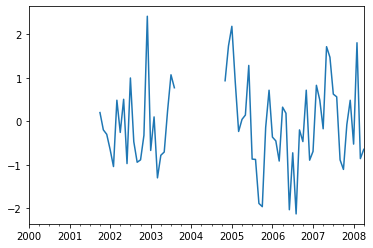

In [16]:
rng = pd.date_range('2000.01.31', periods=100, freq='BM')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts[1:21]=np.nan
ts[44:58]=np.nan
ts.count() ## 66
ts.plot()

<AxesSubplot:>

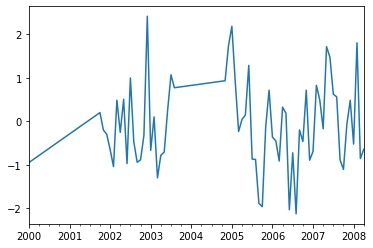

In [19]:
ts.interpolate().count() # 100
ts.interpolate().plot()

<AxesSubplot:>

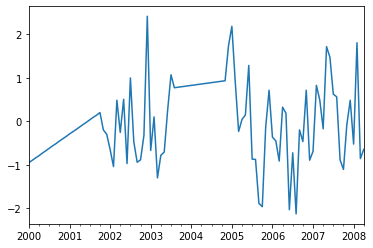

In [21]:
ts.interpolate(method='time').plot()

In [23]:
ts.interpolate().head()

2000-01-31   -0.948994
2000-02-29   -0.894311
2000-03-31   -0.839629
2000-04-28   -0.784946
2000-05-31   -0.730264
Freq: BM, dtype: float64

In [25]:
ts.interpolate(method='quadratic').head()

2000-01-31   -0.948994
2000-02-29   -0.444694
2000-03-31    0.046841
2000-04-28    0.448581
2000-05-31    0.870604
Freq: BM, dtype: float64

In [29]:
ser = pd.Series([4.0, 1.0, 0.0, 3.0, 2.0])
ser.replace(0,5)
ser.replace([0, 1, 2, 3, 4], [4, 3, 2, 1, 0])

0    0.0
1    3.0
2    4.0
3    1.0
4    2.0
dtype: float64

In [34]:
d = {"a": list(range(4)), "b": list("ab.."), "c": ["a", "b", np.nan, "d"]}
df = pd.DataFrame(d)
df.replace('.', np.nan)
df.replace(r"\s*\.\s*", np.nan, regex=True)

,a,b,c
0,0,a,a
1,1,b,b
2,2,NaN,NaN
3,3,NaN,d


In [54]:
l = ["VISTA AES TIETE E UNT N2 600",
"VISTA IT AUUNIBANCO PN N1 1.400",
"OPCAO DE VENDA 04/21 COGNP450ON 4,50COGNE 100.000"]
df=DataFrame({
    'col':l
})
df.col.str.extract(r'(\d*\.*\d*)?$').astype(str).replace(regex={'\.':''})

,0
0,600
1,1400
2,100000


In [65]:
df = pd.DataFrame(np.random.randn(10, 2))
df


,0,1
0,0.516100,-1.273825
1,0.140443,-1.097246
2,-1.200129,-1.257968
3,-0.190381,0.470499
4,-0.339512,1.475863
5,-2.014989,-0.101649
6,-0.663196,-1.206852
7,-0.996107,-1.073538
8,-0.055751,-0.565110
9,0.200097,1.220069


In [66]:
df[np.random.rand(df.shape[0]) > 0.5] = 1.5
df

,0,1
0,0.516100,-1.273825
1,0.140443,-1.097246
2,-1.200129,-1.257968
3,-0.190381,0.470499
4,-0.339512,1.475863
5,-2.014989,-0.101649
6,1.500000,1.500000
7,-0.996107,-1.073538
8,-0.055751,-0.565110
9,0.200097,1.220069


In [71]:
s = pd.Series(np.random.randn(5), index=[0, 2, 4, 6, 7])
reindexed = s.reindex(list(range(8))).fillna(0)
crit = (s > 0).reindex(list(range(8)))
reindexed[crit.fillna(True)]

0    0.783059
1    0.000000
2    1.021866
3    0.000000
4    0.036881
5    0.000000
7    0.300151
dtype: float64

In [7]:
np.nan + 1 # nan
pd.NA + 1 # <NA>
"a" * pd.NA # <NA>

<NA>

In [11]:
bb = pd.read_csv("data/baseball.csv", index_col="id")
bb[bb.columns[:10]].dtypes
bbn = bb.convert_dtypes()
bbn[bbn.columns[:10]].dtypes

player    string
year       Int64
stint      Int64
team      string
lg        string
g          Int64
ab         Int64
r          Int64
h          Int64
X2b        Int64
dtype: object

In [24]:
df = DataFrame({
    'a':['abc', 'def'],
    'b':['abc10', '10def']
})
df1 = df.convert_dtypes()
print(df.dtypes)
print(df1.dtypes)

df.b.str.split()
df1.b.str.split()

a    object
b    object
dtype: object
a    string
b    string
dtype: object


0    [abc10]
1    [10def]
Name: b, dtype: object

# 2.11 Duplicate Labels

In [30]:
s1 = pd.Series([0, 1, 2], index=["a", "b", "b"])
#s1.reindex(["a", "b", "c"]) # ValueError: cannot reindex from a duplicate axis


,index,0
0,a,0
1,b,1
2,b,2


In [34]:
df1 = pd.DataFrame([[0, 1, 2], [3, 4, 5]], columns=["A", "A", "B"])
df1['A']

,A,A
0,0,1
1,3,4
